# CS179 Group Project
### Due: Wed, June 12 2024 (11:59 PM)

In [5]:
import matplotlib.pyplot as plt

import pyGMs as gm
import numpy as np
import torch
import random
import pandas as pd

import requests                                      # reading data
from io import StringIO
import time

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import pyro.poutine as poutine

from IPython.display import display, clear_output  # for iterative plotting

seed = 123
random.seed(seed)
pyro.set_rng_seed(seed)

c:\Users\Fred\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Processing
---

In [17]:
# READ DATA
"""
file_paths = ['.\\2022_LoL_esports_match_data_from_OraclesElixir.csv',
              '.\\2023_LoL_esports_match_data_from_OraclesElixir.csv',
              '.\\2024_LoL_esports_match_data_from_OraclesElixir.csv']
"""

# Read and concatenate all the files
#data_frames = [pd.read_csv(file_path, low_memory=False) for file_path in file_paths]
#data = pd.concat(data_frames, ignore_index=True)


file_path = '.\\2023_LoL_esports_match_data_from_OraclesElixir.csv'
data = pd.read_csv(file_path, low_memory=False)

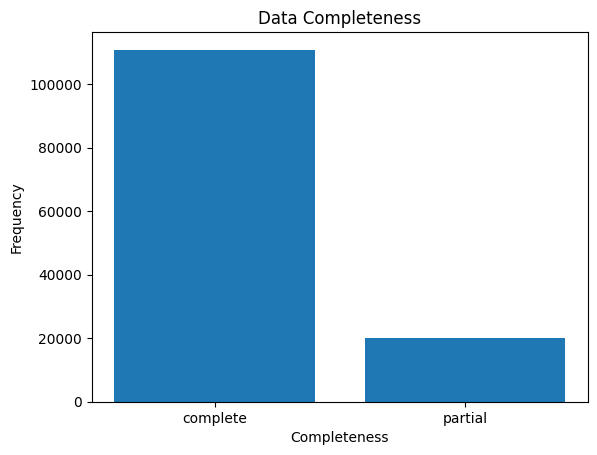

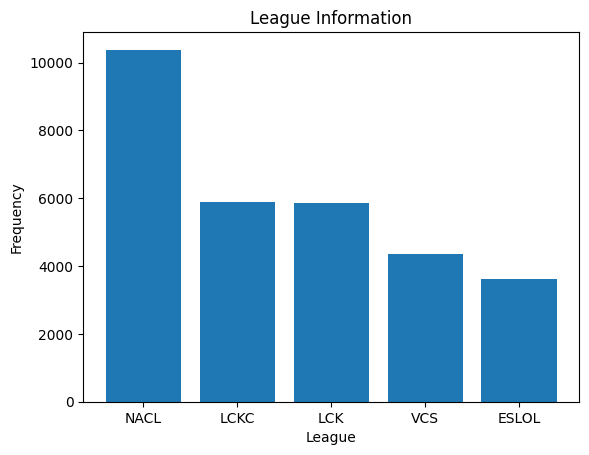

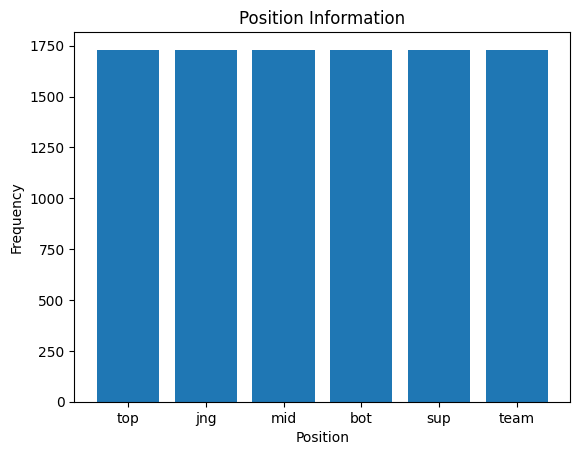

In [18]:
# DATA ANALYSIS

# Completeness Information
completeness_categories = data['datacompleteness'].unique()
completeness_values = []
for completeness in completeness_categories:
    completeness_values.append(data[data['datacompleteness'] == completeness].shape[0])
    
plt.figure()
plt.bar(completeness_categories, completeness_values)
plt.xlabel("Completeness")
plt.ylabel("Frequency")
plt.title("Data Completeness")
plt.show()

# League Information
league_categories = data['league'].unique()
league_values = []
for league in league_categories:
    league_values.append(data[(data['league'] == league) & (data['datacompleteness'] == 'complete')].shape[0])

top_5_freq_leagues = sorted(zip(league_categories, league_values), key=lambda x: x[1], reverse=True)[:5]

league_categories = [league for league, _ in top_5_freq_leagues]
league_values = [count for _, count in top_5_freq_leagues]

plt.figure()
plt.bar(league_categories, league_values)
plt.xlabel("League")
plt.ylabel("Frequency")
plt.title("League Information")
plt.show()


# Position Information
position_categories = data['position'].unique()
position_values = []
for position in position_categories:
    position_values.append(data[(data['position'] == position) & (data['datacompleteness'] == 'complete') & (data['league'] == 'NACL')].shape[0])
    
plt.figure()
plt.bar(position_categories, position_values)
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.title("Position Information")
plt.show()

In [19]:
# TEAM MATCHES (not used yet)
team_data = data[(data['datacompleteness'] == 'complete') & 
                     (data['league'] == 'LCK') & 
                     (data['position'] == 'team')]

teams = team_data['teamname'].value_counts()

game_results = []
game_ids = team_data['gameid'].unique()

for gameid in game_ids:
    game = team_data[team_data['gameid'] == gameid]
    team1 = game[game['result'] == 1]['teamname'].values[0]
    team2 = game[game['result'] == 0]['teamname'].values[0]
    # Team 1 beats Team 2
    game_results.append((team1, team2))

print(game_results)

[('Dplus KIA', 'DRX'), ('Dplus KIA', 'DRX'), ('T1', 'Gen.G'), ('T1', 'Gen.G'), ('Hanwha Life Esports', 'Kwangdong Freecs'), ('Hanwha Life Esports', 'Kwangdong Freecs'), ('BRION', 'Nongshim RedForce'), ('BRION', 'Nongshim RedForce'), ('KT Rolster', 'T1'), ('T1', 'KT Rolster'), ('T1', 'KT Rolster'), ('Dplus KIA', 'Liiv SANDBOX'), ('Dplus KIA', 'Liiv SANDBOX'), ('Gen.G', 'DRX'), ('Gen.G', 'DRX'), ('BRION', 'Kwangdong Freecs'), ('Kwangdong Freecs', 'BRION'), ('BRION', 'Kwangdong Freecs'), ('Liiv SANDBOX', 'Hanwha Life Esports'), ('Hanwha Life Esports', 'Liiv SANDBOX'), ('Liiv SANDBOX', 'Hanwha Life Esports'), ('Nongshim RedForce', 'KT Rolster'), ('KT Rolster', 'Nongshim RedForce'), ('KT Rolster', 'Nongshim RedForce'), ('Dplus KIA', 'Nongshim RedForce'), ('Dplus KIA', 'Nongshim RedForce'), ('Liiv SANDBOX', 'KT Rolster'), ('KT Rolster', 'Liiv SANDBOX'), ('Liiv SANDBOX', 'KT Rolster'), ('Gen.G', 'BRION'), ('Gen.G', 'BRION'), ('T1', 'Kwangdong Freecs'), ('T1', 'Kwangdong Freecs'), ('DRX', 'Non

In [20]:
# PLAYER DATA CALCULATIONS 

def normalize_by_position(df, column, role):
    role_data = df[df['position'] == role]
    mean = role_data[column].mean()
    std = role_data[column].std()
    df.loc[df['position'] == role, column] = (df[df['position'] == role][column] - mean) / std

def prepare_data(data):
    player_data = data[(data['datacompleteness'] == 'complete') & 
                    (data['league'] == 'LCK') & 
                    (data['position'].isin(['top', 'jng', 'mid', 'bot', 'sup']))]


    relevant_columns = ['gameid', 'playername', 'teamname', 'position', 'xpdiffat15', 'golddiffat15', 'damageshare', 'earned gpm', 'result']
    missing_values = player_data[relevant_columns].isnull().sum()
    player_data = player_data[relevant_columns].dropna()


    roles = player_data['position'].unique()
    #metrics = ['xpdiffat15', 'golddiffat15', 'damageshare', 'earned gpm']
    metrics = ['earned gpm']


    for position in roles:
        for metric in metrics:
            normalize_by_position(player_data, metric, position)

    player_game_counts = player_data['playername'].value_counts().reset_index()
    player_game_counts.columns = ['playername', 'num_games']

    player_data = player_data.merge(player_game_counts, on='playername')
    
    X = torch.tensor(player_data[['earned gpm', 'num_games', 'result']].values, dtype=torch.float)

    return player_data, X

player_data, X = prepare_data(data)

unique_game_ids = player_data['gameid'].unique()
split_index = int(len(unique_game_ids) * 0.8)
train_game_ids = unique_game_ids[:split_index]
test_game_ids = unique_game_ids[split_index:]

train_data = player_data[player_data['gameid'].isin(train_game_ids)]
test_data = player_data[player_data['gameid'].isin(test_game_ids)]

X_train = torch.tensor(train_data[['earned gpm', 'num_games', 'result']].values, dtype=torch.float)
X_test = torch.tensor(test_data[['earned gpm', 'num_games', 'result']].values, dtype=torch.float)


In [21]:
# MODEL
def model(earned_gpm, num_games, result):
    with pyro.plate("data", len(earned_gpm)):
        skill = pyro.sample('skill', dist.Normal(0, 1))
        adjusted_skill = skill / torch.sqrt(num_games + 1)  
        pyro.sample('earned_gpm', dist.Normal(adjusted_skill, 1), obs=earned_gpm)  

        scaled_logit = adjusted_skill
        pyro.sample('result', dist.Bernoulli(logits=scaled_logit), obs=result)  


def guide(earned_gpm, num_games, result):
    skill_mean = pyro.param('skill_mean', torch.tensor(0.0))
    skill_std = pyro.param('skill_std', torch.tensor(1.0), constraint=dist.constraints.positive)
    with pyro.plate("data", len(earned_gpm)):
        pyro.sample('skill', dist.Normal(skill_mean, skill_std))

In [22]:
# TRAINING

optimizer = pyro.optim.Adam({'lr': 0.002})
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

# Train loop
num_steps = 15000
for step in range(num_steps):
    loss = svi.step(X[:, 0], X[:, 1], X[:, 2])
    if step % 500 == 0:
        print("Step: ", step, "Loss: ", loss)

Step:  0 Loss:  10332.342529296875
Step:  500 Loss:  10329.57275390625
Step:  1000 Loss:  10316.34912109375
Step:  1500 Loss:  10324.124755859375
Step:  2000 Loss:  10342.587890625
Step:  2500 Loss:  10330.823486328125
Step:  3000 Loss:  10337.2587890625
Step:  3500 Loss:  10312.726806640625
Step:  4000 Loss:  10335.755615234375
Step:  4500 Loss:  10333.893798828125
Step:  5000 Loss:  10337.111328125
Step:  5500 Loss:  10300.412353515625
Step:  6000 Loss:  10319.1201171875
Step:  6500 Loss:  10348.10107421875
Step:  7000 Loss:  10313.473388671875
Step:  7500 Loss:  10322.135498046875
Step:  8000 Loss:  10331.72021484375
Step:  8500 Loss:  10345.96728515625
Step:  9000 Loss:  10334.513916015625
Step:  9500 Loss:  10332.538330078125
Step:  10000 Loss:  10328.357666015625
Step:  10500 Loss:  10330.52294921875
Step:  11000 Loss:  10310.634521484375
Step:  11500 Loss:  10324.02783203125
Step:  12000 Loss:  10315.773681640625
Step:  12500 Loss:  10313.720947265625
Step:  13000 Loss:  10303.6

In [23]:
# ANALYSIS
skill_mean = pyro.param('skill_mean').item()
skill_std = pyro.param('skill_std').item()

print(f"Estimated skill: Mean = {skill_mean}, Std = {skill_std}")

Estimated skill: Mean = -0.006538412533700466, Std = 0.985784649848938


In [25]:
# INDIVIDUAL PLAYER SKILL ANALYSIS

def estimate_skills(data, X):
    data_copy = data.copy()  # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    player_skills = []
    for i in range(len(data_copy)):
        earned_gpm = torch.tensor([X[i, 0]])
        num_games = torch.tensor([X[i, 1]])
        result = torch.tensor([X[i, 2]])

        with torch.no_grad():
            guide_trace = pyro.poutine.trace(guide).get_trace(earned_gpm, num_games, result)
            skill = guide_trace.nodes['skill']['value'].item()
            player_skills.append(skill)

    data_copy['estimated_skill'] = player_skills
    return data_copy

train_data = estimate_skills(train_data, X_train)
test_data = estimate_skills(test_data, X_test)

In [28]:
def calculate_rolling_mean(df, window_size=50):
    df['rolling_skill'] = df.groupby('playername')['estimated_skill'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

def assign_weights(df):
    df['game_weight'] = 1.0 / (df.groupby('playername').cumcount() + 1)
    return df

train_data = assign_weights(train_data)
train_data = calculate_rolling_mean(train_data)

aggregated_skills = train_data.groupby('playername').apply(
    lambda x: pd.Series({
        'weighted_skill': (x['rolling_skill'] * x['game_weight']).sum() / x['game_weight'].sum(),
        'num_games': x['playername'].count()
    })
).reset_index()

def apply_penalty(row):
    if row['num_games'] < 50:
        missing_games = 50 - row['num_games']
        penalty = (0.75 ** missing_games)
        return row['weighted_skill'] * penalty
    return row['weighted_skill']

aggregated_skills['adjusted_skill'] = aggregated_skills.apply(apply_penalty, axis=1)

# Sorting players by the adjusted skill
sorted_players = aggregated_skills.sort_values(by='adjusted_skill', ascending=False)

print(sorted_players[['playername', 'adjusted_skill', 'num_games']].to_string(index=False))

playername  adjusted_skill  num_games
     Chovy    4.557551e-01      109.0
 ShowMaker    4.541669e-01       88.0
    Effort    4.415000e-01       53.0
   Delight    3.579919e-01      109.0
      Kael    3.543491e-01       50.0
    Aiming    3.412421e-01       67.0
    Morgan    3.357248e-01       53.0
     Peter    3.306210e-01       50.0
    Willer    3.205104e-01       50.0
    Rascal    3.070304e-01       90.0
    Peanut    2.812021e-01      109.0
    Clozer    2.748866e-01       50.0
  Gumayusi    2.458829e-01      119.0
     Canna    2.458152e-01       88.0
   BuLLDoG    2.223683e-01       83.0
      Kiin    1.776543e-01       67.0
   Lehends    1.489159e-01       67.0
    FIESTA    1.279694e-01       42.0
     Karis    9.538685e-02       48.0
     Doran    7.716277e-02      109.0
     Keria    7.190483e-02      119.0
      DnDn    6.320208e-02       50.0
      FATE    5.815206e-02       81.0
    Paduck    4.841900e-02       46.0
      Clid    4.109170e-02       49.0
       Jun  

In [453]:
# EVALUATION

def evaluate_team_performance(data, X):
    with torch.no_grad():
        guide_trace = pyro.poutine.trace(guide).get_trace(X[:, 0], X[:, 1], X[:, 2])
        skill = guide_trace.nodes['skill']['value']

    data = data.copy()
    data['estimated_skill'] = skill.numpy()


    data['team_skill'] = data.groupby('teamname')['estimated_skill'].transform('mean')

    predicted_result = (10 * data['team_skill']).apply(lambda x: 1 if x > 0 else 0)
    actual_result = data['result'].values
    

    accuracy = (predicted_result == actual_result).mean()
    return accuracy

train_accuracy = evaluate_team_performance(train_data, X_train)
test_accuracy = evaluate_team_performance(test_data, X_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.506426735218509
Test Accuracy: 0.6275510204081632


In [455]:
def calculate_win_rate(team1, team2, data):
    team1_data = data[data['teamname'] == team1]
    team2_data = data[data['teamname'] == team2]

    team1_skill = team1_data['estimated_skill'].mean()
    team2_skill = team2_data['estimated_skill'].mean()

    win_prob_team1 = 1 / (1 + torch.exp(torch.tensor(team2_skill - team1_skill)))
    win_prob_team2 = 1 / (1 + torch.exp(torch.tensor(team1_skill - team2_skill)))

    return win_prob_team1.item(), win_prob_team2.item()

win_rate_team1, win_rate_team2 = calculate_win_rate("KT Rolster", "Liiv SANDBOX", train_data)
print(f"Win Rate for KT Rolster: {win_rate_team1}")
print(f"Win Rate for T1: {win_rate_team2}")

Win Rate for KT Rolster: 0.5132341993907971
Win Rate for T1: 0.4867658006092029


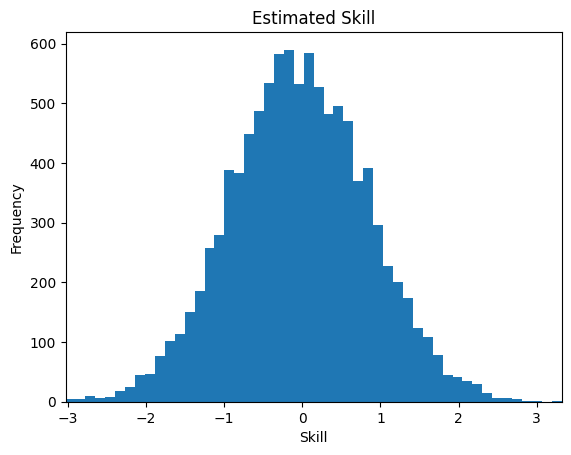

In [206]:
# Histogram (Just drawing based on the estimated skill mean and standard deviation, not the actual data)
skill_distribution = torch.normal(mean=skill_mean, std=skill_std, size=(10000,))
plt.hist(skill_distribution.numpy(), bins=50, label='Estimated Skill')
plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.title('Estimated Skill')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()